<a name='0'></a>

# Deep Residual Networks - ResNet

In the previous implementation of ConvNets architectures, we saw how networks kept getting bigger and bigger year after year. Researchers were starting to realize that depth is essential for performance, but it was extremely hard to train large networks. It is after Sergey Ioffe and Christian Szegedy found that by using a technique called [batch normalization](https://arxiv.org/abs/1502.03167), we can train a networks of over 100 layers. The idea that depth is essential for performance was yet to be proven again!!

[ResNet](https://arxiv.org/pdf/1512.03385.pdf) won the ImageNet Challenge in 2015 and set a record for winning all tasks - classification, localization, detection and segmentation. In 2015, ResNet was the first bigger network of 152 layers. Its error rate on ImageNet Challenge was 3.6, half the previous winner(GoogLeNet). ResNet also went beyond from winning the ImageNet challenge to winning [Microsoft Coco detetction challenge](https://cocodataset.org/#home). 

Still today, ResNet is a powerful architecture and it is advised that you should try it before or instead of building your own architecture.

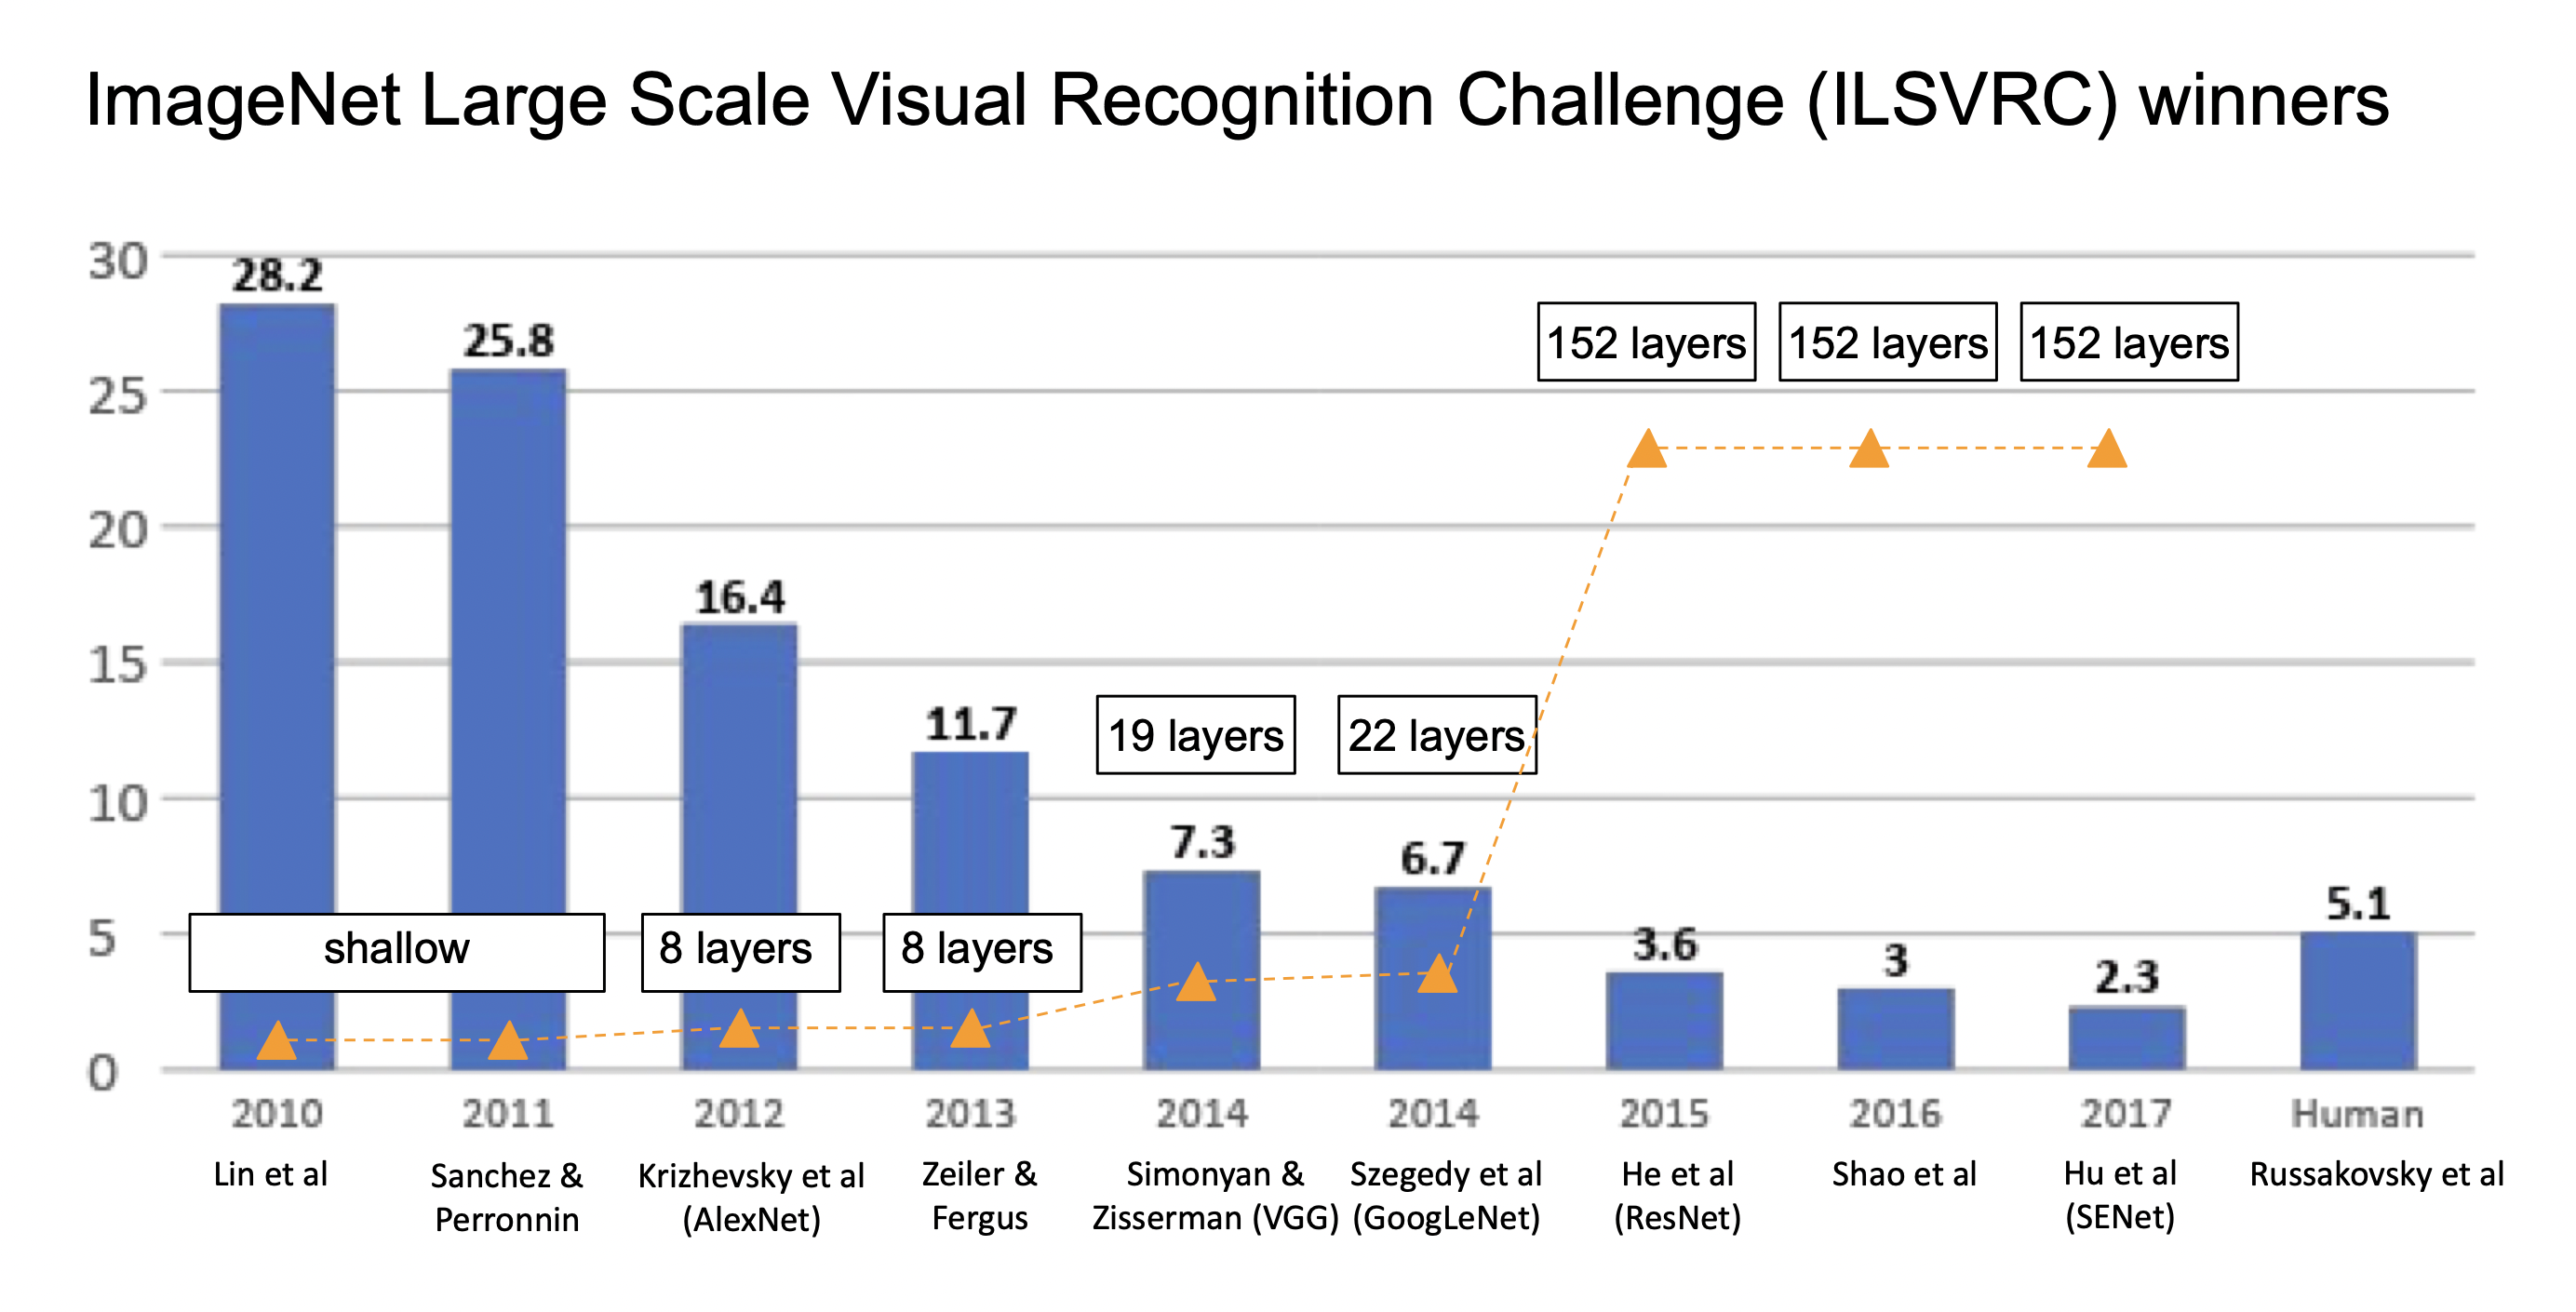

*Image: ImageNet Challenge, 2010-2017. Taken from CS231n, CNNs for Visual Recognition.*


### What's in here: 

  * [1. Motivations for Deep Networks](#1)
  * [2. ResNet Architecture](#2)
  * [3. Implementation](#3)
  * [4. Final Notes](#4)



<a name='1'></a>
## 1. Motivations for Deep Residual Networks

Residual networks addressed a very important problem: `Is learning better networks as easy as stacking more layers?` What Kaiming He and his colleagues found was that the difficulty of training neural networks had less to do with the depth. In their experimentation on Cifar10 and ImageNet datasets, they trained a 20-layer network(shallow) and 50-layer network(deep) and found that although 20-layer network has low training error, it also has a high test error. The same thing happened for 50-layer network. If the issue was depth, the 20-layer would not have a high test error, but it did. That showed that if we can find better ways of training and optimizing neural networks, we can achieve a better test error with more depth. 

Look at the following graphs showing the training and test error of 20-layer and 56-layer networks. 

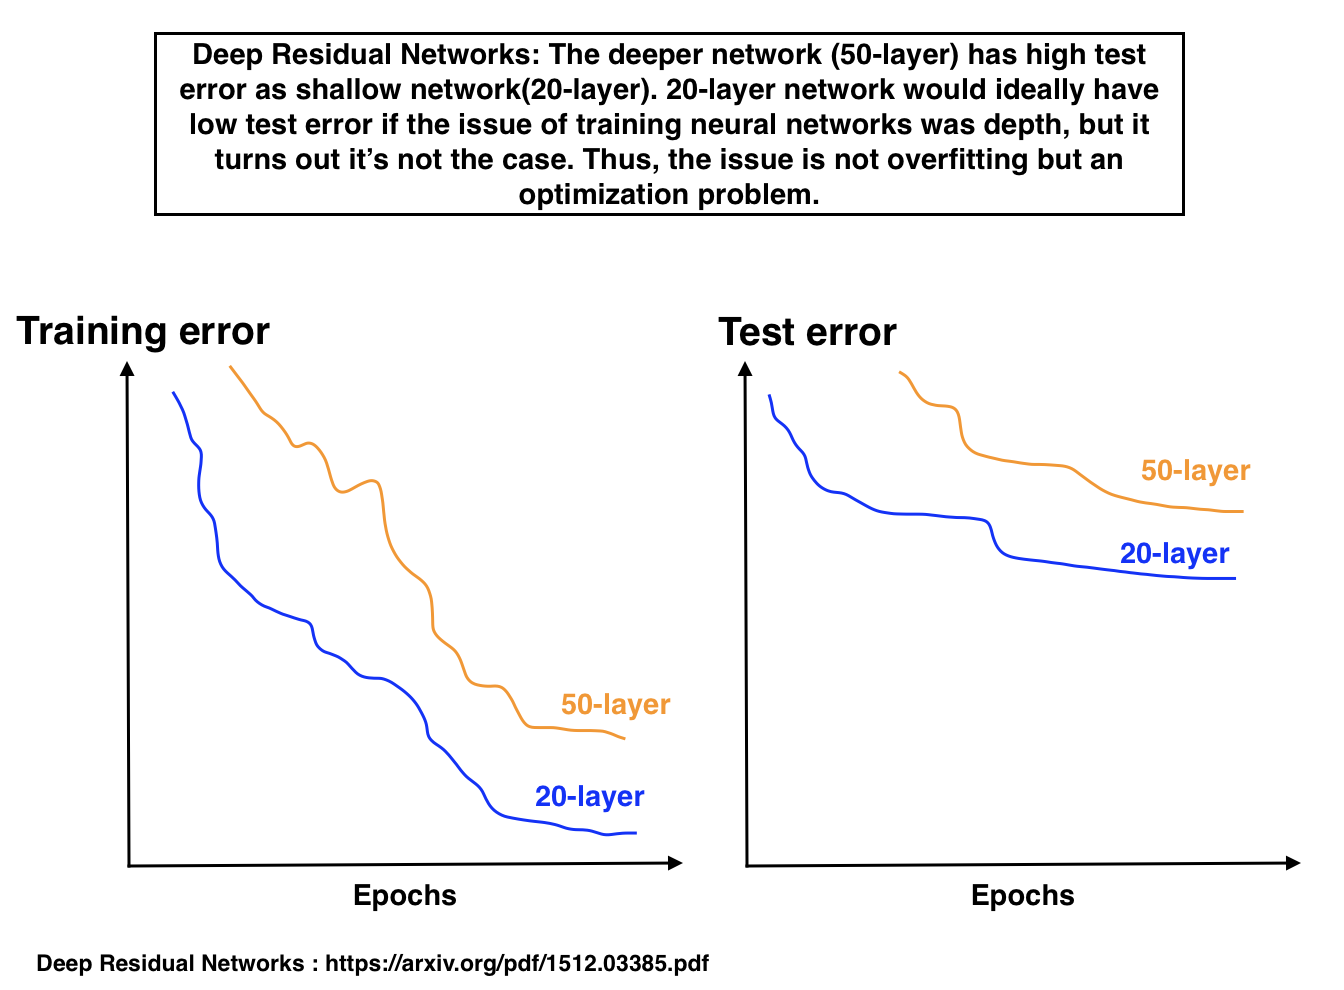

Residual networks also showed that deep plain networks (networks without residual connections) exhibits high training error than shallow networks. 

Kaiming He and his colleagues adrressed the problem by using residual shortcut connections. And hence, deep residual networks. We will learn more about shortcut connections later. 

<a name='2'></a>
## 2. ResNet Architecture

The main building block of the Residual Network is the residual blocks or units with shortcut connections. Residual blocks were kinds like inspired by VGG blocks and GoogLeNet inception modules, but the special thing about them is that they have shortcut connections. Shortcut (identity)connections don't have any parameter.

Below is the structure of the residual block of the Residual Networks 50/101/152 layers.

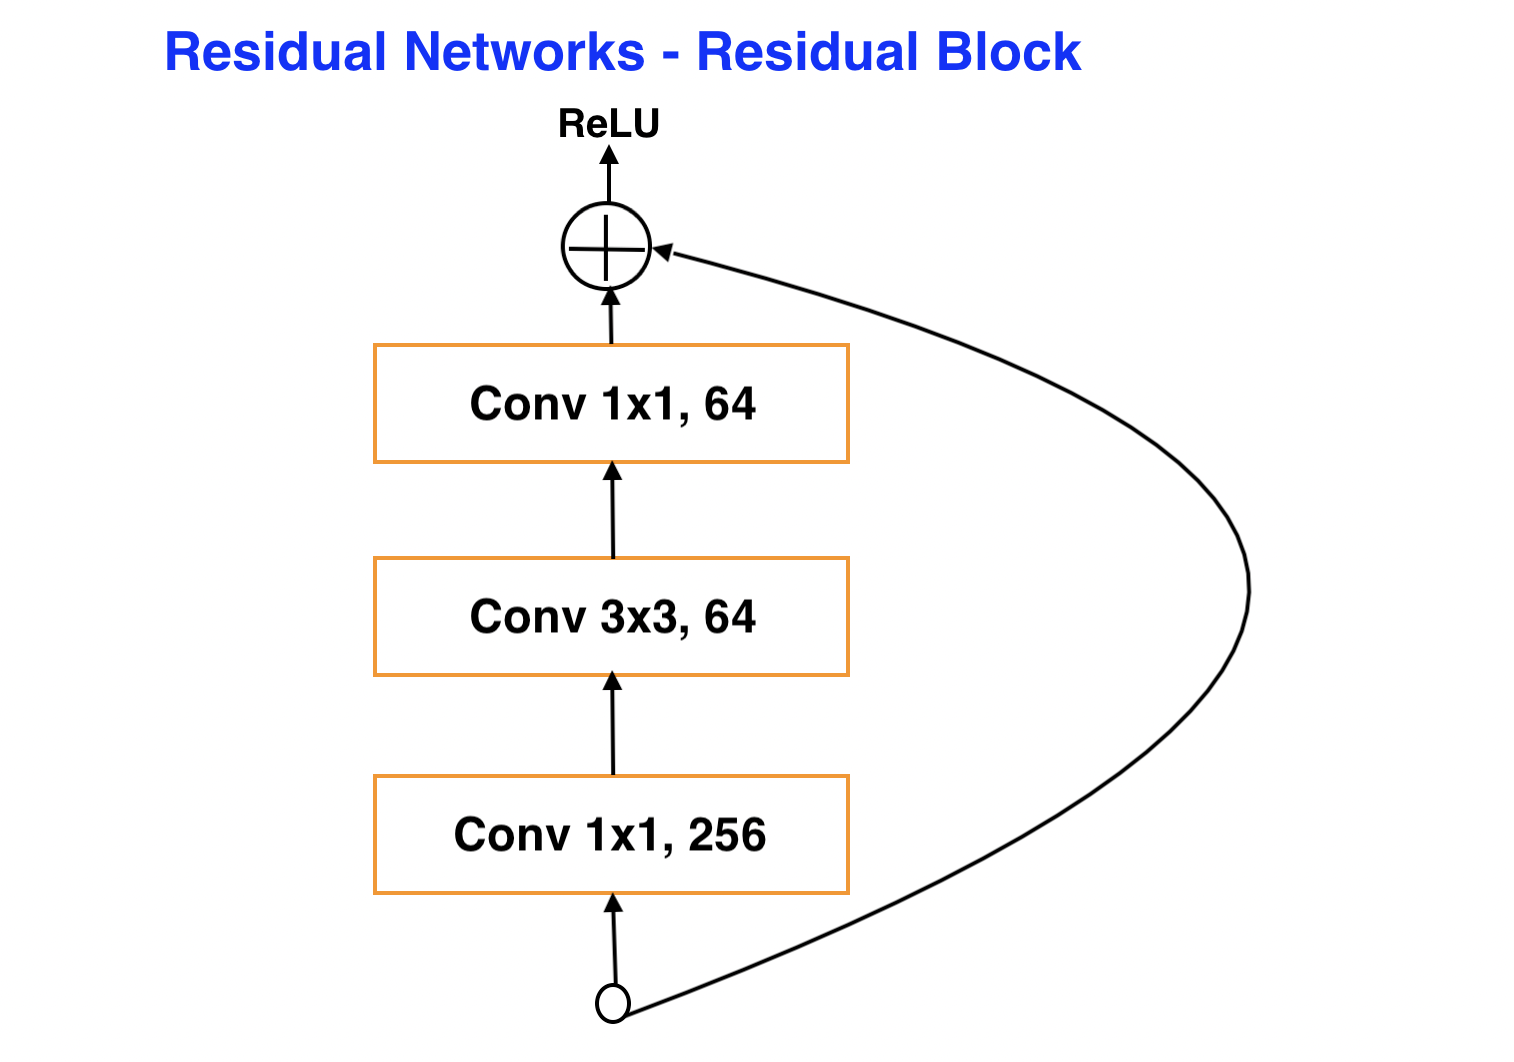

*Image: Residual block*

A residual block is made of 3 stacked convolutional layers: 1x1, 3x3, and 1x1 convolutions. Two 1x1 convolutions are used for reducing(and restoring) the channel dimensions. In order to add these two parallel paths(as seen in image above), the input and the output must have same shape. Note that such residual block is only for ResNet 50, 101, and 152.  

To clarify the above, there are two types of residual connections: identity and projections connections. ***Identity*** connections are used when the input and output have the same dimensions as they can be added together whereas the ***projections*** are used when the input and output have different dimensions where 1x1 convolution is inserted into the shortcut connection to increase the dimension of the input, thus making it possible to add them. An alternative to using identity connection when the input and output have different dimensions is to use zero-padding because that can increase dimensions too. 

The change in shapes(hence the need of projection shortcut) is caused by the change in number of filters which also change the output feature maps(number of filters and the output feature maps are equivalent in a convolutional layer). If you can look at the table below, you see that we double the filters in each layer in residual units after block of layers, and as a result, for every beginning of the every block(conv3_1, conv4_1, conv5_1), the shape of a previous layer and shape of block output will be different(the block output is 4 times the input). To overcome that, we add 1x1 convolution layer with 4 times the filters of the input convolution layer in a block. If this sounds difficult, we will see it in the practice.

Below image illustrates identity and projections connections in ResNet-50/101/152.





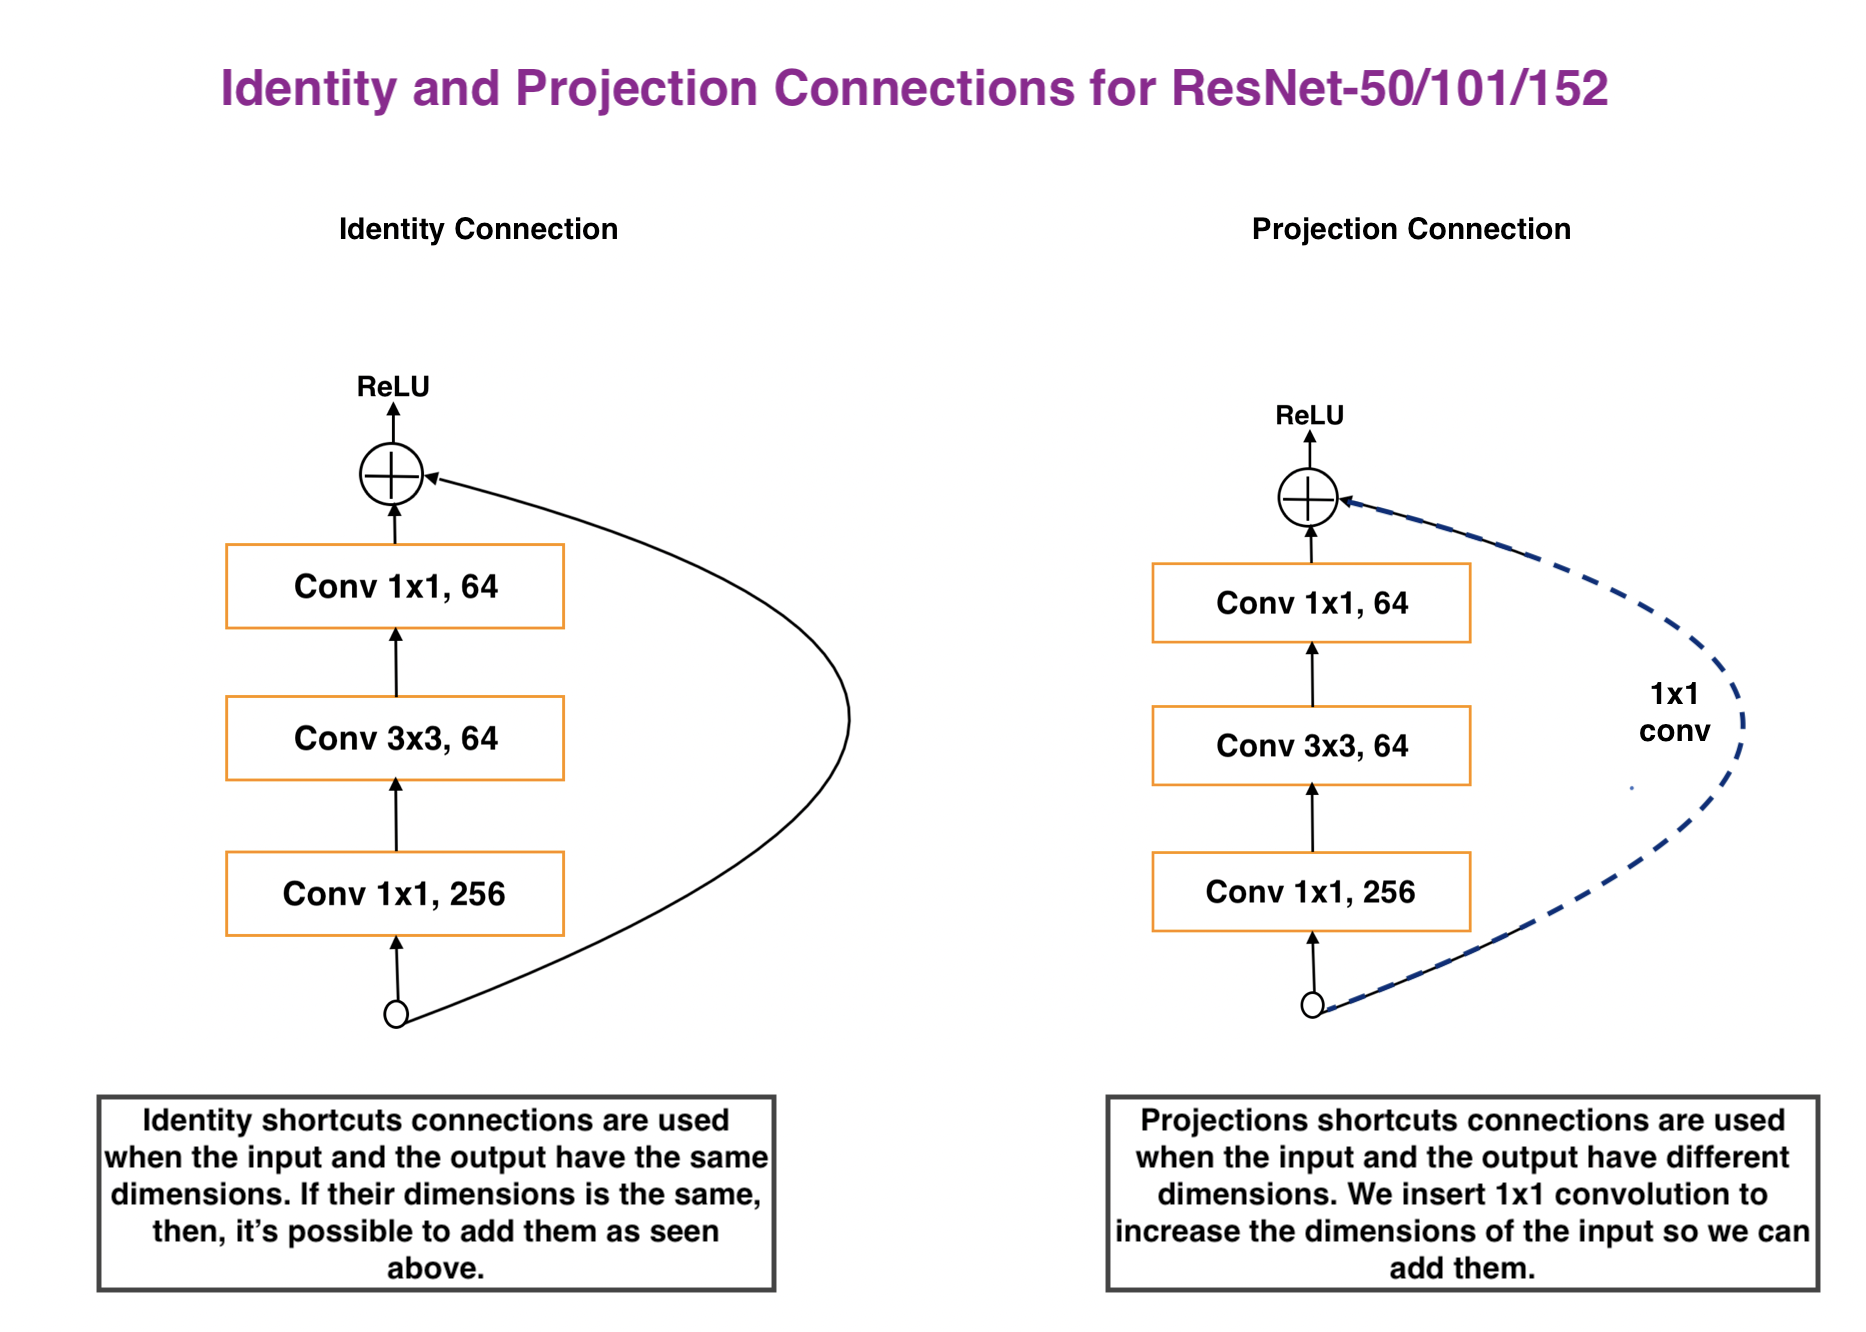

The residual block of ResNet 34-layers is pretty much like above but it doesn't have 1x1 convolution, but instead two 3x3 convolutions with 64 filters each.

ResNet designers trained its several versions that differ in number of layers. Their baseline was a plain network(without a residual units) of 34 layers with learnable parameters(33 convolutional and 1 fully connected layer). The plain 34 layers achieved `10.02%` top-5 error rate on ImageNet while the same network with residual connections(ResNet-34) achieved top-5 error rate of `5.71%`. That goes to show the effectiveness of residual connections!!

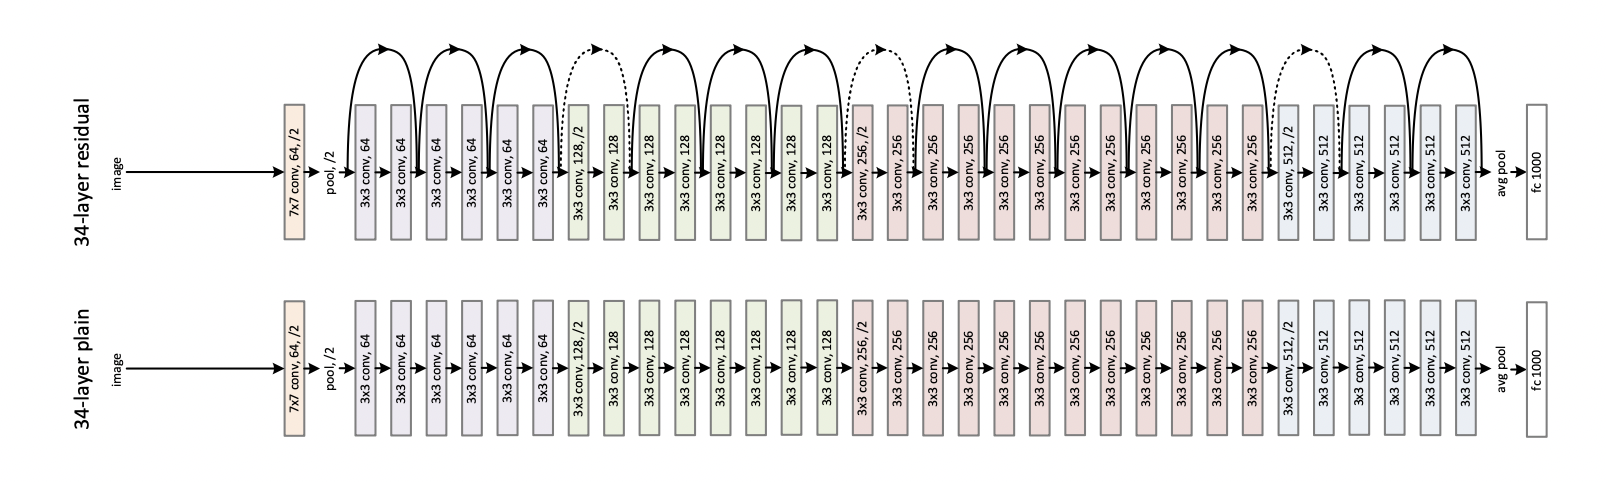

*Image: Plain 34 layers and ResNet-34. The solid shorcut connections shows that input of the residual block and the output has same dimensions and they can be added, whereas dotted shortcuts shows where the input and output are of different dimensions and 1x1 convolution is added into the shortcut connection to increase dimension. The connections with 1x1 convolutions are called projections, while the straight solid shorcuts are called identity shortcuts.*

Below table summarize the number of layers and the type of layers used in ResNet-18, ResNet-30, ResNet-50, ResNet-101, ResNet-152. Note that 18, 30, 50, 101, and 152 denotes the number of learnable layers in a particular architecture. The learnable layers are typically those that have parameters such as convolutional and fully connected layers. Below table summarizes all ResNet versions. 

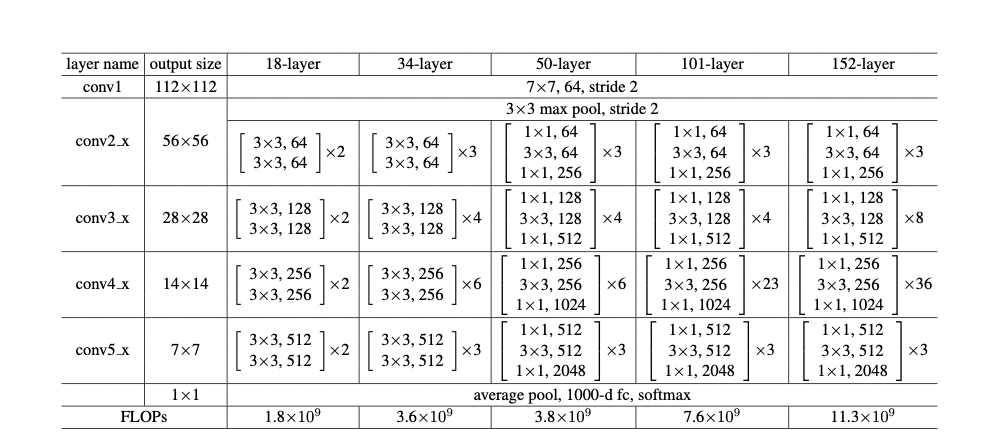

*Table: ResNet-18, ResNet-50, ResNet-101, ResNet-152. Depicted from the [ResNet paper](https://arxiv.org/pdf/1512.03385.pdf).* 

Here are other things to know about the ResNet architecture:

* All ResNet versions start with a 7x7 convolutional layer with 64 filters and stride of 2. It is followed by 3x3 maxpooling layer with stride of 2. This block of convolution and pooling layer is for downsampling the input image. 

* All convolutional layers are followed by batch normalization layer, right before applying ReLU activation function. Because convolutional layers are implemented with activations as hyperparameter in modern deep learning tools, we will omitt it to obey the design rule of putting batch normalization after convolution layer before activation.

* ResNet doesn't use fully connected layers. After all residual blocks, we add the average pooling layer and a classification layer with 1000 units (per ImageNet dataset) with softmax activation. For our implementation, we will use 10 units in the output classification layer. 

Now that we understand the ResNet architecture, let's implement the ResNet-50. 

<a name='3'></a>
## 3. Implementation of ResNet-50

#### Set up

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

In order to implement ResNet-50, piece by piece, we will: 

* Implement the identity and projection connections blocks. 
* Implement the whole ResNet-50 model. 

The same ideas can be used for other versions such as ResNet-34/101/152. Keep in mind that every convolutional layer is followed by batch normalization and ReLU activation layers. 



#### Identity Block

Identity block comprises of 1x1 convolution, 3x3 convolution and 1x1 convolution with a direct shortcut connection from the input to the output. 1x1 convolutions are used to reduce(or restore) the dimensions. 

Since to add the input and the output require them to have the same dimensions, as we will see, identity blocks are used right after projection blocks in each convolution blocks because the input/output tensors have the same dimensions.

In [2]:
def identity_block(input_tensor, filters, strides=1):
  """
  input tensor
  filters: a tuple of 3 filters to be used in convolutional layers
  strides = 1 for all conv layers
  """
  f1, f2, f3 = filters

  x = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=strides)(input_tensor)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=strides)(x)
  x = layers.BatchNormalization()(x)
  
  x = layers.Add()([x, input_tensor])
  output_tensor = layers.ReLU()(x)

  return output_tensor

We can verify if what we did above is correct by plotting the identity block. To plot it, we assume that there is a prior convolutional layer of 256 filters just to test it. 

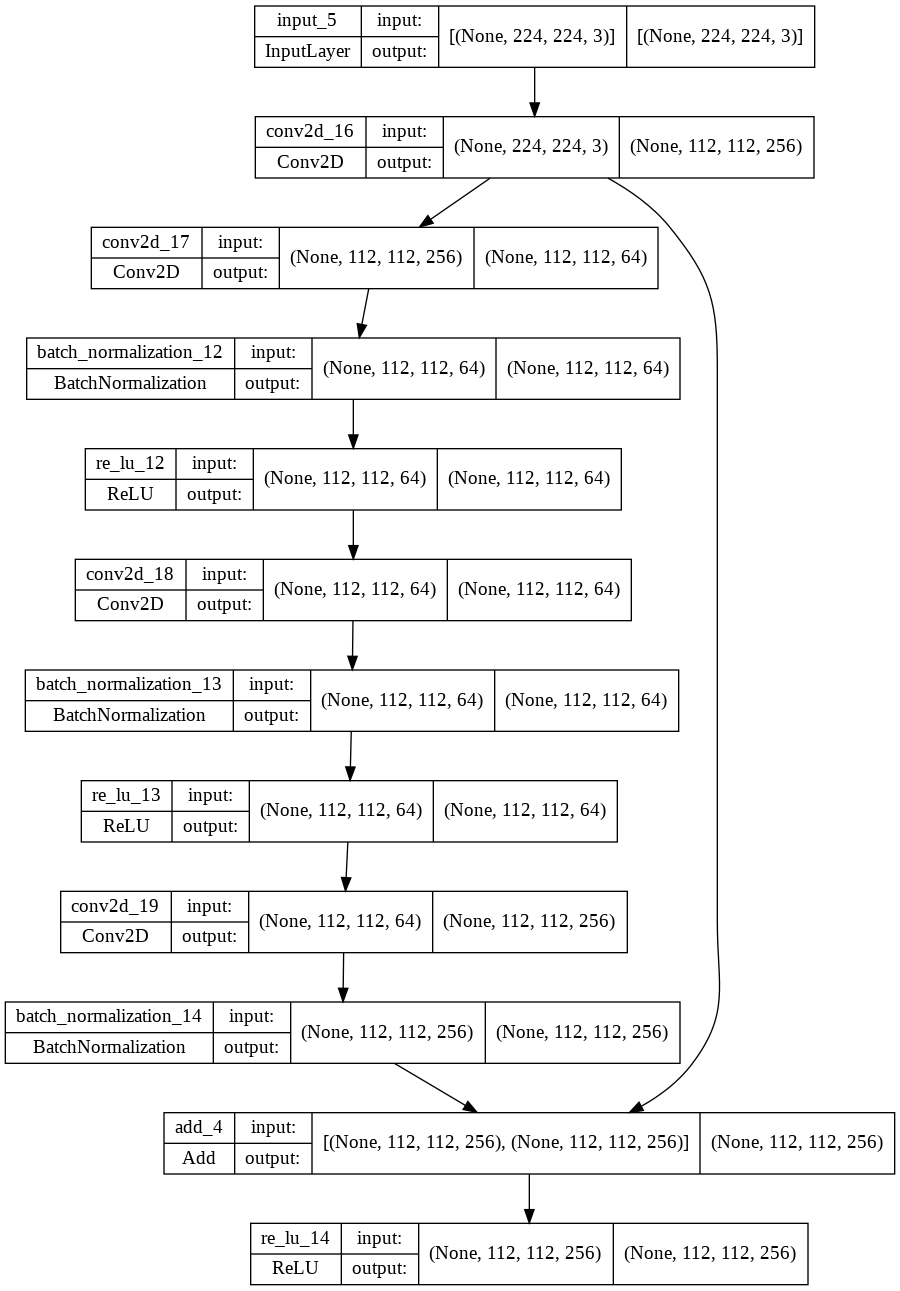

In [7]:
input = layers.Input(shape=(224, 224, 3))
x = layers.Conv2D(filters=256, kernel_size=(7,7), strides=2, padding='same')(input)

output = identity_block(x, (64, 64, 256))
plot_model(tf.keras.Model(input, output), show_shapes=True)

#### Projection Block

Projection blocks are also like identity blocks but they have 1x1 convolution at the shortcut connection. 1x1 convolution is used for increasing the dimension of the input tensor so that it can be added with the output tensor. 

Projection blocks are always placed at the beginning of every convolution block (denoted as conv2-x, conv3-x, conv4-x, conv5-x).

In [8]:
def projection_block(input_tensor, filters, strides=2):
  """
  A projection block is a block that has 1x1 conv layer in the shortcut connection
  1x1 convolution at shortcut connection is used for increasing the input dimension.
  input_tensor: input tensor
  filters: a tuple of 3 filters to be used in 3 conv layers at the main path, the 1x1conv shorcut takes third filter
  strides of 2 at the first conv layers in conv block conv3_1, conv4_1, and conv5_1 for downsampling purpose
  """

  f1, f2, f3 = filters
  x = layers.Conv2D(filters=f1, kernel_size=(1,1), strides=strides)(input_tensor)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f2, kernel_size=(3,3), strides=1, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=1)(x)
  x = layers.BatchNormalization()(x)

  # 1x1 conv projection shortcut
  shortcut = layers.Conv2D(filters=f3, kernel_size=(1,1), strides=strides)(input_tensor)
  shortcut = layers.BatchNormalization()(shortcut)

  x = layers.Add()([x, shortcut])
  output_tensor = layers.ReLU()(x)

  return output_tensor

We can also try to plot the projection block. Since there is 1x1 convolution that is responsible for increasing the input dimension, we do not need to add anything other than just plotting the block given the input tensor.

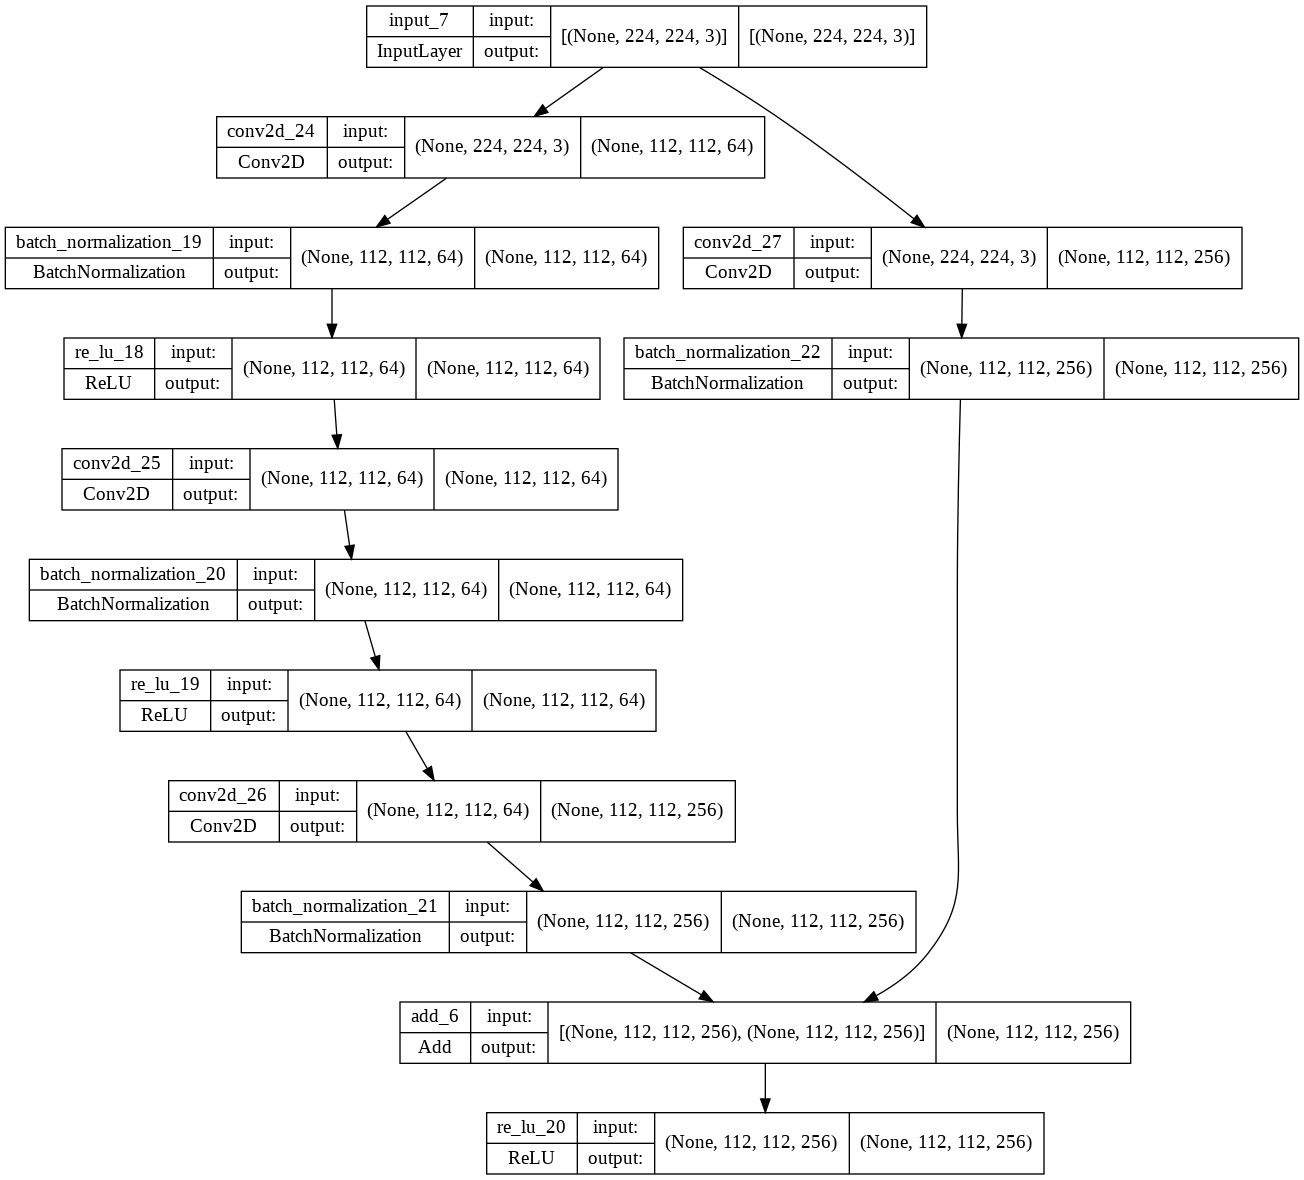

In [10]:
input = layers.Input(shape=(224, 224, 3))

output = projection_block(input, (64, 64, 256))
plot_model(tf.keras.Model(input, output), show_shapes=True)

#### Building the rest of ResNet-50 Model

Now that we have identity block and projection block, we can design the rest of the ResNet-50 architecture. All we have to know is that for every ResNet Conv block(denoted by `conv2_x, conv3_x, conv4_x, conv5_x`), the first block will always be the projection block because the previous dimension is different to the block output, and in order to add them, we have to increase the dimension of previous output tensor. 

After projection block, the rest will be identity blocks. The identity shortcut connections are used when the input tensor and output tensor has same the same dimension. Quoting the paper, "identity shortcuts are particularly important for not increasing the complexity of the bottleneck architectures."

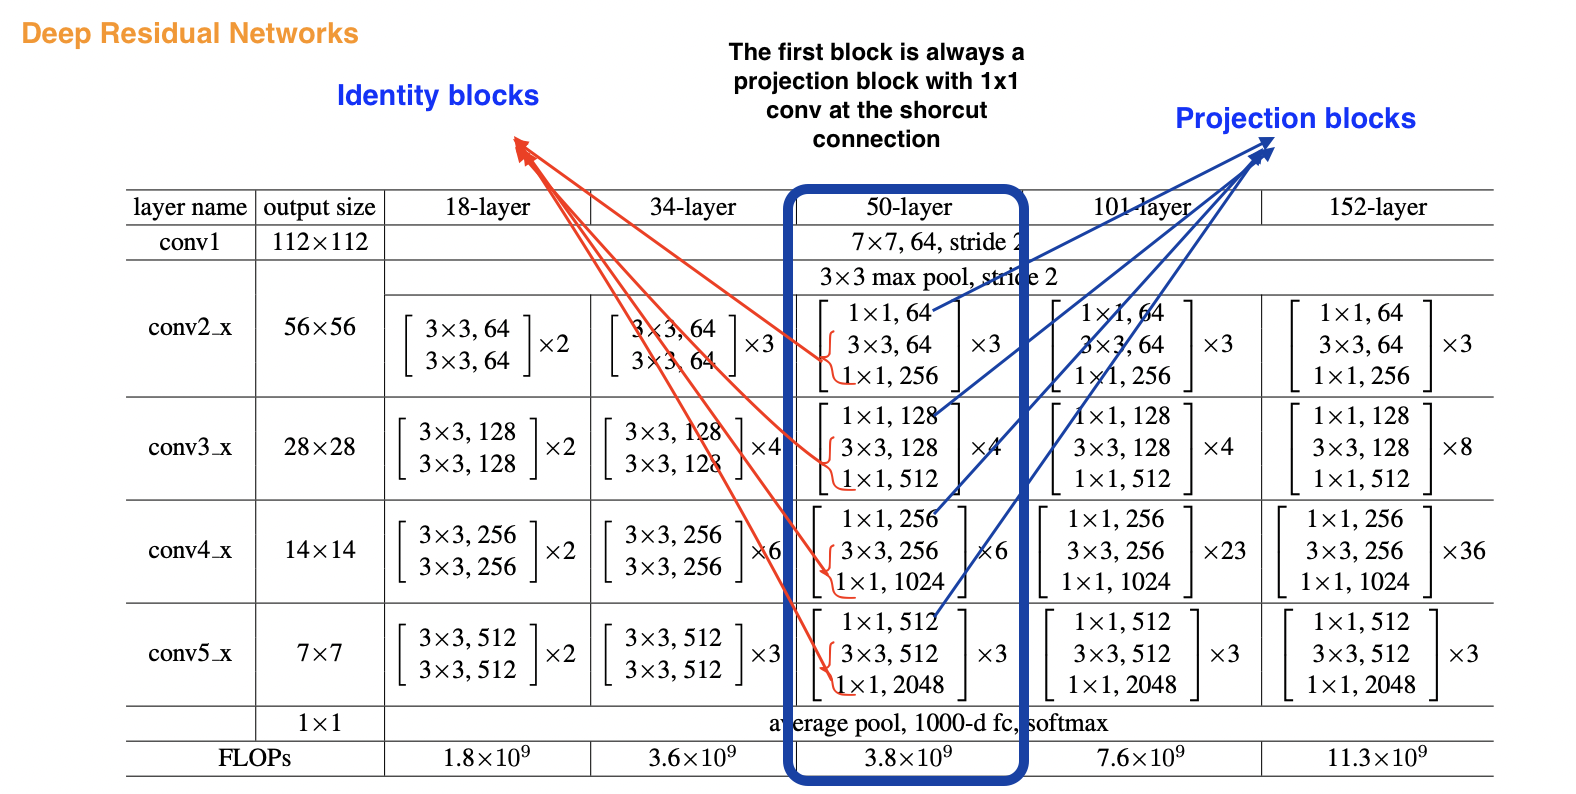

In [11]:
input = layers.Input(shape=(224, 224, 3))

x = layers.Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same')(input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

x = projection_block(x, (64, 64, 256))
x = identity_block(x, (64, 64, 256))
x = identity_block(x, (64, 64, 256))

x = projection_block(x, (128, 128, 512))
x = identity_block(x, (128, 128, 512))
x = identity_block(x, (128, 128, 512))
x = identity_block(x, (128, 128, 512))

x = projection_block(x, (256, 256, 1024))
x = identity_block(x, (256, 256, 1024))
x = identity_block(x, (256, 256, 1024))
x = identity_block(x, (256, 256, 1024))
x = identity_block(x, (256, 256, 1024))
x = identity_block(x, (256, 256, 1024))

x = projection_block(x, (512, 512, 2048))
x = identity_block(x, (512, 512, 2048))
x = identity_block(x, (512, 512, 2048))

x = layers.GlobalAvgPool2D()(x)
x = layers.Dense(1000, activation='softmax')(x)

resnet50 = tf.keras.Model(input, x, name='ResNet-50')

In [12]:
resnet50.summary()

Model: "ResNet-50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_28 (Conv2D)             (None, 112, 112, 64  9472        ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_23 (BatchN  (None, 112, 112, 64  256        ['conv2d_28[0][0]']              
 ormalization)                  )                                                         

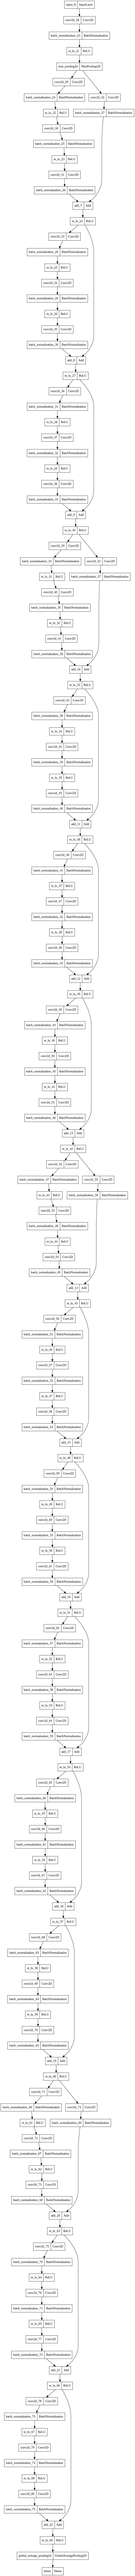

In [13]:
plot_model(resnet50)

<a name='5'></a>
## 5. Final Notes

Residual Networks have been one of the greatest inventions in the field of deep learning and computer vision. With just introducing shorcut connections, they have made it possible to train large networks, and it inspired other CNN architectures such as [SENet](https://arxiv.org/abs/1709.01507) and [ResNeXt](https://arxiv.org/abs/1611.05431). What SENet and ResNeXt mostly did was tweaking the residual units and shortcut connections and they improved the performance. SENet won classification task on ILSVRC 2017 with top error rate of `2.251%`. I recommend you skim through these papers if you have time, especially ResNeXt.

We have implemented ResNet-50, but the ideas and techniques used are similar to how you would implement ResNet-34, ResNet-101, and ResNet-152.

In the next notebooks, we will talk about other CNN architectures that kept coming after ILSVRC challenge.


## [BACK TO TOP](#0)